In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import math
from scipy.stats import entropy

Load the Datasets

In [ ]:
df_unusual = pd.read_csv('delay_unusual_traffic.csv')
df = pd.read_csv('normal.csv')

# Drop rows with NaN in the 'Source' column
df.dropna(subset=['Source'], inplace=True)
df.dropna(subset=['Payload Length'], inplace=True)


# Sort the DataFrame by 'Time'
df.sort_values(by='Time', inplace=True)

# Convert 'Time' column to datetime for calculations
df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Calculate the inter-arrival time per source IP address
df['Inter-Arrival Time'] = df.groupby('Source')['Time'].diff()

df['Inter-Arrival Time (s)'] = df['Inter-Arrival Time'].dt.total_seconds()

# Drop rows with NaN in the 'Source' column
df.dropna(subset=['Inter-Arrival Time (s)'], inplace=True)

# Calculate entropy of payload sizes
payload_entropy = df.groupby('Source')['Payload Length'].apply(lambda x: entropy(np.bincount(x)))
df['Payload_Entropy'] = payload_entropy.reindex(df['Source']).values


In [ ]:
# Drop rows with NaN in the 'Source' column
df_unusual.dropna(subset=['Source'], inplace=True)
df_unusual.dropna(subset=['Payload Length'], inplace=True)

# Sort the DataFrame by 'Time'
df_unusual.sort_values(by='Time', inplace=True)

# Convert 'Time' column to datetime for calculations
df_unusual['Time'] = pd.to_datetime(df_unusual['Time'], unit='s')

# Calculate the inter-arrival time per source IP address
df_unusual['Inter-Arrival Time'] = df_unusual.groupby('Source')['Time'].diff()

df_unusual['Inter-Arrival Time (s)'] = df_unusual['Inter-Arrival Time'].dt.total_seconds()

# Drop rows with NaN in the 'Source' column
df_unusual.dropna(subset=['Inter-Arrival Time (s)'], inplace=True)
# Calculate entropy of payload sizes
payload_entropy = df_unusual.groupby('Source')['Payload Length'].apply(lambda x: entropy(np.bincount(x)))
df_unusual['Payload_Entropy'] = payload_entropy.reindex(df_unusual['Source']).values

In [ ]:
df_unusual['Delay'] = (df_unusual['Inter-Arrival Time (s)'] > 6).astype(int)
df_unusual['Unusual'] = (df_unusual['Payload Length'] > 150).astype(int)
df_unusual['Anomaly'] = (df_unusual['Delay'] | df_unusual['Unusual']).astype(int)


In [ ]:
# Preprocess the data
labels=df_unusual['Anomaly']
df_unusual.drop('Anomaly', axis=1, inplace=True)
df_unusual.drop('Delay', axis=1, inplace=True)
df_unusual.drop('Unusual', axis=1, inplace=True)        # might help improve the models performance
df_unusual.drop('Time', axis=1, inplace=True)
df_unusual.drop('Source', axis=1, inplace=True)
df_unusual.drop('Destination', axis=1, inplace=True)
df_unusual.drop('Protocol', axis=1, inplace=True)
df_unusual.drop('Info', axis=1, inplace=True)
df_unusual.drop('Inter-Arrival Time', axis=1, inplace=True)
df_unusual.drop('No.', axis=1, inplace=True)
df_unusual.drop('Sequence Number', axis=1, inplace=True)

df.drop('Time', axis=1, inplace=True)
df.drop('Source', axis=1, inplace=True)
df.drop('Destination', axis=1, inplace=True)
df.drop('Protocol', axis=1, inplace=True)
df.drop('Info', axis=1, inplace=True)
df.drop('Inter-Arrival Time', axis=1, inplace=True)
df.drop('No.', axis=1, inplace=True)
df.drop('Sequence Number', axis=1, inplace=True)

# Calculate Payload-Inter-Arrival Time Ratio by dividing 'Payload Length' with 'Inter-Arrival Time (s)'
df['Payload-Inter-Arrival Time Ratio'] = df['Payload Length']/df['Inter-Arrival Time (s)']
df_unusual['Payload-Inter-Arrival Time Ratio'] = df_unusual['Payload Length']/df_unusual['Inter-Arrival Time (s)']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Fit the scaler on the data and transform it
scaled_data = scaler.fit_transform(df)

# Convert scaled data back to a DataFrame
df = pd.DataFrame(scaled_data, columns=df.columns)

scaler = MinMaxScaler()
# Fit the scaler on the data and transform it
scaled_data = scaler.fit_transform(df_unusual)

# Convert scaled data back to a DataFrame
df_unusual = pd.DataFrame(scaled_data, columns=df_unusual.columns)

In [ ]:
# Define the anomaly detection models
ocsvm = OneClassSVM(kernel="rbf", gamma=0.1)

# Train the models and measure the training time
start=time.time()
ocsvm.fit(df)
ocsvm_time = time.time() - start


# Predictions
ocsvm_prediction = ocsvm.predict(df_unusual)
print("OneClassSVM Prediction:",ocsvm_prediction)


OneClassSVM Prediction: [-1 -1 -1 ... -1 -1 -1]


In [ ]:
normal_test = np.count_nonzero(labels == 0)
anomaly_test = np.count_nonzero(labels == 1)
print(f'Normal_test: {normal_test}')
print(f'Anomaly_test: {anomaly_test}')

Normal_test: 1535
Anomaly_test: 2051


In [ ]:
print(f'Anomaly captured by OneClassSVM: {np.count_nonzero(ocsvm_prediction == -1)}')

Anomaly captured by OneClassSVM: 3428


In [ ]:
ocsvm_incorrect = sum((labels == 0) & (ocsvm_prediction == -1))     # False positives
print(f'Incorrectly classified as anomaly by OneClassSVM: {ocsvm_incorrect}')


Incorrectly classified as anomaly by OneClassSVM: 1480


In [ ]:
ocsvm_correct = sum((labels == 1) & (ocsvm_prediction == -1)) * 100      # True positives
print(f'Correctly classified as anomaly by OneClassSVM (%): {ocsvm_correct/anomaly_test}%')

Correctly classified as anomaly by OneClassSVM (%): 94.97805948317894%


In [ ]:
mse_ocsvm = mean_squared_error(labels,ocsvm_prediction)
print(mse_ocsvm)

2.600948131622978


In [ ]:
# ocsvm_prediction_mapped = np.where(ocsvm_prediction == -1, 1, 0)
ocsvm_prediction_mapped = [0 if pred == 1 else 1 for pred in ocsvm_prediction]
conf_matrix_ocsvm = confusion_matrix(labels, ocsvm_prediction_mapped)
print(conf_matrix_ocsvm)

[[  55 1480]
 [ 103 1948]]


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


0.49280560686214875


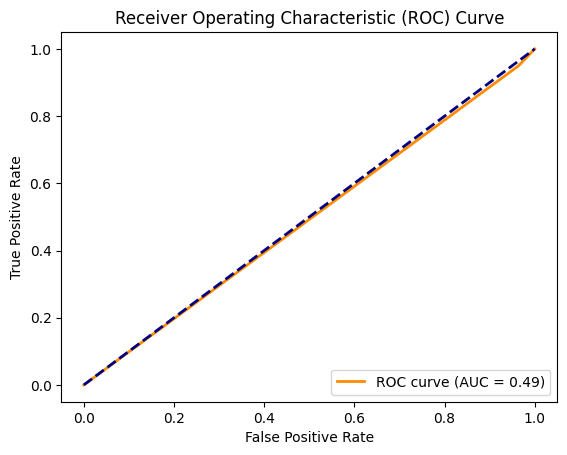

In [ ]:
# Assuming 'y_true' contains true labels (0 for normal, 1 for anomalies) and 'predictions' contains model predictions (-1 for anomalies)
fpr, tpr, thresholds = roc_curve(labels, ocsvm_prediction_mapped, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(f'Training time OneClassSVM: {ocsvm_time}')

Training time OneClassSVM: 0.04808330535888672
